<div style="float:right;color:#000000;text-align:left;border-bottom:3px solid #000000;border-top:3px solid #000000;">
    Biophysics 2021-2022<br/>Exercises week 7<br/>Viktor Van Nieuwenhuize</div>
<h1> Chapter 5: oscillations </h1>
<h2> 5.3: Hopf Bifurcations </h2>
In this exercise we consider the Holling-Tanner model:
\begin{align*}
    N' &= N \left(1 - \frac{N}{7} \right) - w\frac{N}{1+N}N \\
    P' &= 0.1N \left(1 - \frac{N}{7} \right)
\end{align*}

We will start this analysis using $w = 0.3$. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from ipywidgets import interact
from IPython.display import display
from sympy import solve, diff, symbols, Matrix, Symbol
import sympy.core.numbers as spn
import time

# interactive plots
%matplotlib widget

<h3> 0. General functions </h3>
We declared a static class called `Markup`. This class contains static string variables that can be used for markup in printed strings. A string using markup starts with the proper code (e.g. `Markup.RED` for red text, `Markup.B` for bold text etc.) and should always be terminated by the ending character (`Markup.END`). Alternatively, we also defined static methods for combinations that are often used in this notebook. These methods take a single string as an argument and return the string with the corresponding markup applied to it. Using these static methods has the advantage that you cannot forget the `Markup.END` character.

In [2]:
class Markup:
    RED = '\033[91m'
    GREEN = '\033[92m'
    B = '\033[1m'
    U = '\033[4m'
    RB = RED + B
    GB = GREEN + B
    END = '\033[0m'

    @staticmethod
    def b_red(s: str) -> str:
        return Markup.RB + s + Markup.END

    @staticmethod
    def b_green(s: str) -> str:
        return Markup.GB + s + Markup.END

    @staticmethod
    def bold(s: str) -> str:
        return Markup.B + s + Markup.END

In the following cell we create a function for the Holling-Tanner system. This function is then used in the next function to calculate the solutions of this system. Finally we created 2 more functions, one which calculates the Jacobian of the system, and another which then determines the eigenvalues using the Jacobian.

The function calculates the solutions for the system leaving $w$ as a variable. This means that solving the system will take a bit longer then when solving for a set parameter $w$. This does however yield a major speed up in the next section where the solutions for many different values of $w$ need to be calculated.

When calculating the solutions for 500 different values of $w$, the first approach, where the value for $w$ is left as a parameter, solving the system and then substituting each value into this solution took $3.7s$. However solving the system 500 times for each specific value took around $107s$. Thus we see a major speedup in the first method, which is about 29 times faster.
The extra time added for solving the more complex system quickly becomes insignificant with increasing values of $w$.

In [3]:
def holling_tanner(N, P, w):
    def N_prime(N, P, w):
        return N*(1 - N/7) - w*N*P/(1 + N)

    
    def P_prime(N, P, w):
        return 0.1*P*(1 - P/N)
    
    return np.array([N_prime(N, P, w), P_prime(N, P, w)])


def gen_solutions():
    """
    Calculate the general solutions of the Holling-Tanner system
    """
    N, P, w = symbols("N, P, w")
    return solve(holling_tanner(N, P, w), [N, P])


def sub_solution(solution, w_):
    """
    Calculate the solutions of the Holling-Tanner 
    system for a specific value of w, by substituting
    the value into the general solution.
    """
    w = Symbol('w')
    return [(n, p) if isinstance(n, spn.Float) else 
            (n.subs([(w, w_)]), p.subs([(w, w_)])) for n, p in solution]


def jacobian(N_sol=None, P_sol=None, w_sol=None):
    """
    Calculate the general or specific jacobian, 
    depending on which parameters are not None
    """
    N, P, w = symbols("N, P, w")
    X = Matrix(holling_tanner(N, P, w))
    Y = Matrix([N, P])
    J = X.jacobian(Y)
    return J.subs([(N, N_sol), (P, P_sol), (w, w_sol)])


def eig(jacobian):
    J = np.array(jacobian, dtype=float)
    eigval, eigvec = np.linalg.eig(J)
    return eigval

Using these functions it is possible to calculate general solutions for the equations. These solutions are shown in the next cell.

We see that there are 3 solutions for the system of equations. However, drawing any conclusions about them is still difficult. The second and third solutions are hard to interpret. We will come back on these solutions in the next section when we fill in values for $w$.

In [4]:
# calculate the general solution
solution = gen_solutions()

# use display() to make the Sympy objects appear "pretty"
print(Markup.bold('General Jacobian:'))
display(jacobian())

print(Markup.bold('\n\nGeneral Solution of the system:'))
display(Matrix([(Symbol('N_Solution'), Symbol('P_Solution'))] + solution))

General Jacobian:


Matrix([
[N*P*w/(N + 1)**2 - 2*N/7 - P*w/(N + 1) + 1,  -N*w/(N + 1)],
[                             0.1*P**2/N**2, 0.1 - 0.2*P/N]])



General Solution of the system:


Matrix([
[                                                                                                                                                                                                                                                           N_Solution,                                                                           P_Solution],
[                                                                                                                                                                                                                                                                  7.0,                                                                                    0],
[(49.0*w**2 - 64.1560597293818*w*sqrt(0.583333333333333*w**2 - w + 0.761904761904762) - 84.0*w + 54.9909083394701*sqrt(0.583333333333333*w**2 - w + 0.761904761904762) + 50.0)/(-7.0*w + 9.16515138991168*(0.583333333333333*w**2 - w + 0.761904761904762)**0.5 + 6.0), -3.5*w + 4.58257569495584

<h3> 1. Investigating the solutions for $w=0.3$ </h3>
Having defined the necessary functions to solve the system, we can tackle the first couple of questions. 

We start with using a constant value of for $w$ being $w=0.3$. The equilibrium points can be found by substituting the value of $w$ into the solution using `subs()` from `Sympy`.

Finally we create functions, to print the solutions, their eigenvalues and their type of stability.

In [5]:
def print_evals(evals):
    sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    for n, e in enumerate(evals):
        print(f'\t     >> λ{str(n+1).translate(sub)} = {e}')
        

def print_stability(e1, e2):
    print_evals((e1, e2))
    if np.imag(e1) == 0 and np.imag(e2) == 0:
        if e1 > 0 and e2 > 0:
            s = 'n unstable equilibrium'
        elif e1 < 0 and e2 < 0:
            s = ' stable equilibrium'
        else:
            s = ' saddle node'
    else:
        if np.real(e1) > 0:
            s = 'n unstable spiral'
        elif np.real(e2) < 0:
            s = ' stable spiral'
        else:
            s = ' Hopf'
    print(Markup.b_green(f'We have a{s}.\n'))

        
def print_solution(X, Y, n, w_):
    print(Markup.b_red(f'Solution {n+1}: ') + f'(N, P) = ({X}, {Y})')
    evals = eig(jacobian(X, Y, w_))
    print_stability(*evals)

In [6]:
w_ = 0.3
print(Markup.bold(f'w = {w_}'))
solution = gen_solutions()  # general solution

# substitute the value of w, enumerate over them and print them
for n, (N_sol, P_sol) in enumerate(sub_solution(solution, w_)):
    print_solution(N_sol, P_sol, n, w_)

w = 0.3
Solution 1: (N, P) = (7.00000000000000, 0.0)
	     >> λ₁ = -1.0
	     >> λ₂ = 0.1
We have a saddle node.

Solution 2: (N, P) = (5.23671568590896, 5.23671568590896)
	     >> λ₁ = -0.4681762629945063
	     >> λ₂ = -0.16841770762381325
We have a stable equilibrium.

Solution 3: (N, P) = (-1.33671568590896, -1.33671568590896)
	     >> λ₁ = 4.895064171394134
	     >> λ₂ = -0.07615727560575297
We have a saddle node.



Looking at these solutions, we can see that we find 3 different solutions.

\begin{equation*}
\begin{cases}
N = P > 0 \\
N = P < 0 \\
N = 7, P = 0 
\end{cases}
\end{equation*}

The first solution is the only one we're interested in. The second solution is not a physical one since it is not possible to have a negative number of prey or predators. The last solution is determined by the carrying capacitance. This equation point will be the same for all values of $w$. 

The reason why the numbers of prey and predators are the same for the equilibrium point comes from the constants we chose in our system of equations. Here we chose that there needs to be 1 prey to keep 1 predator alive. The physical solution is also stable for this value of $w$.
The equilibrium is stable because the eigenvalues are both real and negative. The conditions for other kinds of equilibria are:

<ol>
  <li> <b>Unstable equilibrium</b>: </li>
    The eigenvalues are real and positive
    
  <li> <b>Stable equilibrium</b>: </li>
    The eigenvalues are real and negative
    
  <li> <b>Saddle node bifurcation</b>: </li>
    Both eigenvalues are real, but one is positive and the other is negative
    
  <li> <b>Unstable spiral</b>:</li>
    Both eigenvalues have an imaginary part and the real part is positive
    
  <li> <b>Stable spiral</b>:</li>
    Both eigenvalues have an imaginary part and the real part is negative
    
  <li> <b>Hoph bifurcation</b>:</li>
    Both eigenvalues have an imaginary part and the real part is zero
</ol>

A Hoph bifurcation occurs when both eigenvalues are complex and the real values are 0. At this point the equilibria switches between an unstable spiral and a stable spiral.

<h3> 2. How do the solutions change in function of $w$ </h3>
In this section we will examine how the solutions for the Holling-Tanner change for different values of $w$. We will reuse many of the functions that we defined in the previous sections.

<h4> 2.1 Examining the stability </h4>
We start the analysis by examining the real and imaginary components of the eigenvalues. From the previous section we know how this determines their stability. The values real and complex eigenvalues are plotted to show how they evolve in function of $w$.

In [7]:
def eval_components(w_):
    """
    Calculate the eigenvalues for a list of
    different values of w. We then split the
    eigenvalues into their real and imaginary
    components.
    """
    evals = np.zeros((len(w_), 2), dtype=np.cdouble)
    gen_solution = gen_solutions()
    gen_jac = jacobian()
    N, P, w = symbols("N, P, w")
    for n, w_sol in enumerate(w_):
        N_sol, P_sol = sub_solution(gen_solution, w_sol)[1]
        evals[n] = eig(gen_jac.subs([(N, N_sol), (P, P_sol), (w, w_sol)]))
    evals = evals.T
    return np.real(evals), np.imag(evals)


def plot_evals(ax, w_):
    """
    Plot the real and imaginary parts of 
    the eigenvalues for different values of w.
    We also add labels for the different kinds
    of bifurcations we see.
    """
    real, imag = eval_components(w_)
    ax.hlines(0, 0, 10, colors='black')
    ax.plot((w, w), real, 'o', c='blue', label='Real eigenvalue')
    ax.plot((w, w), imag, 'o', c='red', label='Imaginary eigenvalue')
    
    ax.plot((0.4, 0.9, 8), (-0.25, 0, 0), 'o', c='green', label='Bifurcations')
    ax.text(0.55, -0.50, f'Stable equilibrium\n{" "*12}<->\n{" "*3}to stable spiral', c='green', fontweight='bold')
    ax.text(1, -0.10, 'Hopf bifurcation', c='green', fontweight='bold')
    ax.text(8.1, -0.10, 'Hopf bifurcation', c='green', fontweight='bold')
    
    ax.set_xlabel(r'$w$')
    ax.set_ylabel('Magnitude')
    ax.set_title(r'Eigenvalues for different values of $w$')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

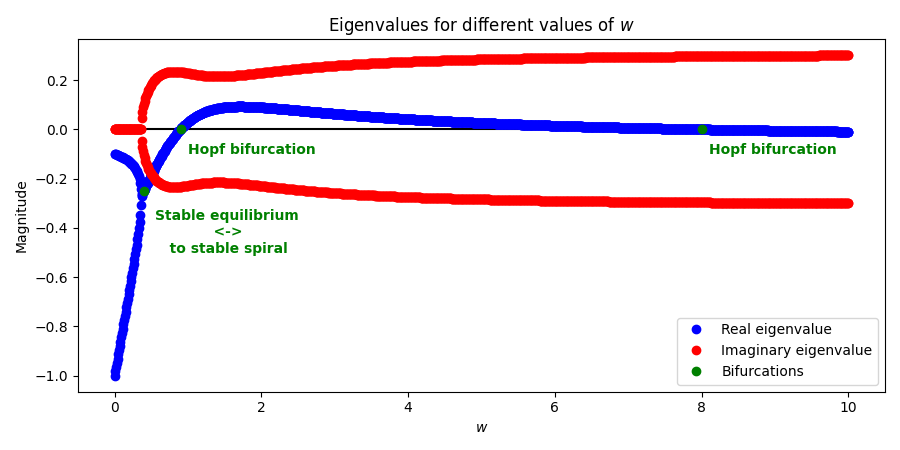

In [8]:
# Plot the eigenvalues in function of w
f1, axes1 = plt.subplots(nrows=1, ncols=1, figsize=(9, 4.5))
w = np.linspace(0, 10, 1000)
plot_evals(axes1, w)
f1.tight_layout()
plt.show()

In the above plot we can see the evolution of the real and imaginary parts of the system for values of $w$ between $0$ and $2$. We can notice 2 Hopf bifurcations. One at around $w = 0.9$ and another one at around $w = 8$. At these points we see a switch between a stable and an unstable spiral. Finally we also notice that at around $w = 0.4$ we have a switch between a stable equilibrium point and a stable spiral. Here the 2 real parts become equal to each other. The imaginary parts split of from zero and become equal, but opposite values.

<h4> 2.2 Plotting the solutions </h4>
Finally in the following plots we will show how these different values of $w$ affect the system. Using these plots we will also be able to visually see how the different kinds of equilibria behave.

In [9]:
def euler_int(start, f, dt, steps, *args, **kwargs):
    """
    Use Euler integration on a system of equations.
    This function can be used for systems with any number of equations.
    Arguments and keyword arguments for the system of equations
    should be passed at the end of the function.
    """
    eul = np.zeros((steps, len(start)))
    eul[0] = start
    
    for i in range(steps-1):
        eul[i+1] = eul[i] + dt*f(*eul[i], *args, **kwargs)
        
    return eul.T # return the transposed array so we can use X, Y, Z = euler_int( ... )


def arrow_components(euls, arrow_step):
    """
    function that calculates the position and directions
    for the arrows we put on the paths. This function is
    written in a way so it works in both 2D and 3D.
    """
    it = range(10, len(euls[0]), arrow_step)
    pos = np.array([[e[i] for i in it] for e in euls])
    dirs = np.array([[e[i+1] - e[i] for i in it] for e in euls])
    return pos, dirs
            

def normalize(x, y):
    N = (np.hypot(x, y))
    N[N==0] = 1
    x /= N
    y /= N
    return x, y


def get_color_range(N, c_map_name):
    """
    create a range of N discrete colors from a matplotlib colormap
    """
    cmap = cm.get_cmap(c_map_name)
    return [cmap(i) for i in np.linspace(0, 1, N)]


def plot_paths(ax, start_locs, func, steps, size, *args, arrow_step=35, color='red', cmap=None, **kwargs):
    for n, params in enumerate(start_locs):
        euler = euler_int(params, func, steps, size, *args, **kwargs)
        
        # plot the lines
        ax.plot(*euler, color=cmap[n] if cmap else color)
        
        # plot the arrows
        pos, dirs = arrow_components(euler, arrow_step)
        normal_vec = normalize(*dirs)
        ax.quiver(*pos, *normal_vec, color=cmap[n], scale=40, headlength=4)

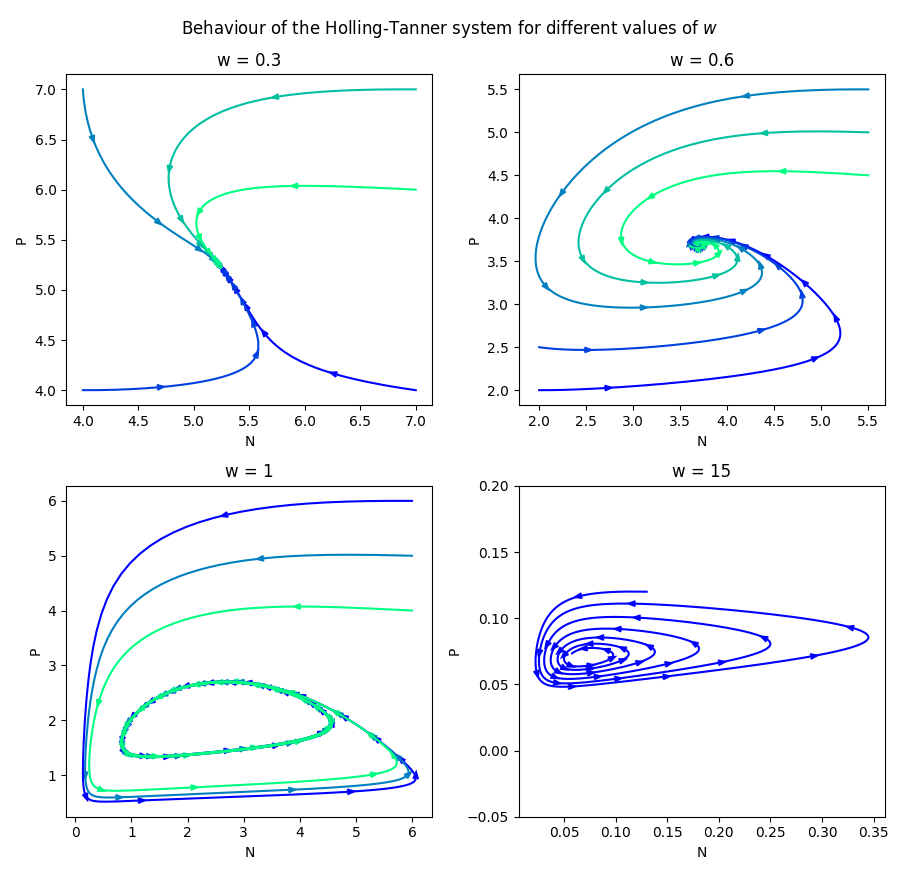

In [10]:
# plotting data lists -> [plot00, plot01, plot10, plot11]
w_list = [0.3, 0.6, 1, 15]
start_list = [
    [(7, 4), (4, 4), (4, 7), (7, 7), (7, 6)], 
    [(2, 2), (2, 2.5), (5.5, 5.5), (5.5, 5), (5.5, 4.5)],
    [(6, 6), (6, 5), (6, 4)],
    [(0.13, 0.12)]
]
steps_list = [250, 1000, 1000, 1300]

# plot the system for different values of w to see their behaviour
f2, axes2 = plt.subplots(nrows=2, ncols=2, figsize=(9, 8.75))
for ax, w, start, n in zip(axes2.ravel(), w_list, start_list, steps_list):
    plot_paths(ax, start, holling_tanner, 0.1, n, w, cmap=get_color_range(len(start), 'winter'))
    ax.set_title(f'w = {w}')
    ax.set_xlabel('N')
    ax.set_ylabel('P')
    
ax.set_ylim(-0.05, 0.2)
f2.suptitle(r'Behaviour of the Holling-Tanner system for different values of $w$')
f2.tight_layout()

# Determine the middle of the spiral
x_mid, y_mid = euler_int(start_list[1][-1], holling_tanner, 0.1, steps_list[1], w_list[1]).T[-1]


def init():
    """
    Init function that is executed at the start of
    the animation. This function is used to set the
    initial axis limits of the plot
    """
    # make the axis limits global variables so we can
    # manipulate them dynamically in the animate() funcion
    global x_min, x_max, y_min, y_max
    x_min, y_min = 2, 2
    x_max, y_max = 5.5, 5.5
    axes2[0][1].set_xlim(x_min, x_max)
    axes2[0][1].set_ylim(y_min, y_max)
    return axes2.ravel()

def animate(i):
    # make sure we're using the global variables
    global x_min, x_max, y_min, y_max
    
    # calculate the difference between the current limits and the middle of the plot
    # and add or subtract this from the current limits to get a new limit closer to the middle
    x_min = (x_min + np.abs(x_min - x_mid)/100) 
    x_max = (x_max - np.abs(x_max - x_mid)/100)
    y_min = (y_min + np.abs(y_min - y_mid)/100)
    y_max = (y_max - np.abs(y_max - y_mid)/100)
    
    # update the plots with the new limits
    axes2[0][1].set_xlim(x_min, x_max)
    axes2[0][1].set_ylim(y_min, y_max)
    return axes2.ravel()


# start an animation
anim = FuncAnimation(f2, animate, interval=50, frames=500, init_func=init, blit=True, repeat=True)

We can now verify from those plots that the predicted behaviours of the system do in fact occur for the different values of $w$. We can see a stable equilibrium, a stable spiral, a limit cycle and another stable spiral. 

The second plot, where $w = 0.6$ is animated. This is because it is more difficult to visually show that we indeed have a spiral. The spirals are a lot less close together than in the plot for $w = 15$, where it is more obvious that we have a spiral.

We also notice that no matter the value of $w$ the populations are always limited. It is thus not possible for the populations to explode and increase indefinitely. For each value of $w$ there is either a point which populations go towards, or there is a limit cycle on which there is an infinite back and forth between the populations. 

To double check our code we will use the print functions from the start of the exercise to determine which kind of equilibrium points we have for the values of $w$ in the plot above. Once again we find the same results.

In [11]:
gen_solution = gen_solutions()
for w_sol in w_list:
    print(Markup.bold(f'w = {w_sol}:'))
    print_solution(*(sub_solution(gen_solution, w_sol)[1]), 1, w_sol)

w = 0.3:
Solution 2: (N, P) = (5.23671568590896, 5.23671568590896)
	     >> λ₁ = -0.4681762629945063
	     >> λ₂ = -0.16841770762381325
We have a stable equilibrium.

w = 0.6:
Solution 2: (N, P) = (3.69463772249643, 3.69463772249642)
	     >> λ₁ = (-0.12809623552621358+0.21547636217564428j)
	     >> λ₂ = (-0.12809623552621358-0.21547636217564428j)
We have a stable spiral.

w = 1:
Solution 2: (N, P) = (2.19258240356726, 2.19258240356725)
	     >> λ₁ = (0.02921619511755558+0.2279924760909782j)
	     >> λ₂ = (0.02921619511755558-0.2279924760909782j)
We have an unstable spiral.

w = 15:
Solution 2: (N, P) = (0.0706566428297225, 0.0706566428164237)
	     >> λ₁ = (-0.02238309394028996+0.30490364915500384j)
	     >> λ₂ = (-0.02238309394028996-0.30490364915500384j)
We have a stable spiral.

